# **Datapreprocessing.py**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data = pd.read_csv('/content/drive/MyDrive/2024_1.csv', encoding='euc-kr')

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

print(data.head())
# Define split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Split the data into training, validation, and testing sets
train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio))
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio))

# Save the splits to CSV files if needed
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

       관측지점              관측시간  관측온도  관측습도    관측기압  관측풍속   관측풍향  관측최대풍속  \
0     구미_산단  2024-01-19 19:40   5.0  68.9  1022.8   1.1   42.2     3.4   
1  홍릉_숲내부5m  2024-01-18 05:50   1.8  90.7  1014.4   0.2   98.3     0.5   
2     대전_산단  2024-01-05 12:40   8.3  70.0  1012.3   0.8  253.1     3.6   
3     종로_주거  2024-01-14 20:40  -0.6  84.0  1012.7   0.8  311.1     2.7   
4      청주_숲  2024-01-26 06:20  -6.8  82.1  1008.0   0.4  141.8     0.9   

   관측미세먼지  관측초미세먼지  ...  (AVOC)배관관측온도  (BVOC)관측온도  (BVOC)관측습도  (BVOC)관측기압  \
0    19.4     13.0  ...         104.2         5.0        69.0      1022.8   
1    45.9     44.8  ...         105.2         1.8        90.7      1014.4   
2    61.7     50.4  ...         102.9         8.3        69.8      1012.3   
3    45.0     41.7  ...         104.3        -0.6        83.3      1012.7   
4    15.5     12.0  ...         106.1        -6.8        82.2      1008.0   

   (BVOC)관측풍속  (BVOC)관측풍향  (BVOC)관측최대풍속  (BVOC)관측미세먼지  (BVOC)관측초미세먼지  \
0         1.1       

# **MLP.py**

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

#CPU 혹은 GPU 사용, GPU우선적으로 사용가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
# 이전의 전러치 코드에서 저장한 데이터 사용, val_data는  아마 eval에서 사용예정
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제,추후 필요없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 데이터셋 축소, 시연에서는 10%만 사용, 이후에는 숫자만 조정으로 데이터사이즈 조정,
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2) #overfiting 방지를 위한 drop

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    #현재는 미세먼지 농도 "수치"를 예측하는것인 모델이고
    #"수치"를 또 분류하려면 layer를 추가하면됨 ex)softmax(다중분류  ex:저 중 고) , binary(이진분류 ex:저 고)


model = MLP()

# 손실 함수, 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   # 0.01로 20인경우 5번째부터 verfiiting 발생  0.001에 epoch 20이 적당해보임

# 모델 학습
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    #모델 성능 임시 테스트용, 삭제해도 무관
    #model.eval()
    #with torch.no_grad():
      #  test_outputs = model(X_test)
       # test_loss = criterion(test_outputs, y_test)

    #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Loss: {test_loss.item():.4f}')
# 모델 평가는 다른파일에서 실행하므로 이 파일에서는 test후 결과를 nparray로 반환하기까지만함

# 예측 함수 정의
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    return y_pred.numpy()

# 예측후 결과 저장
predicted_values = predict(model, X_test)

#결과를 npy값으로 저장, 다음파일에서 사용가능
np.save('MLP.npy', predicted_values)

# **eval_vis.py**

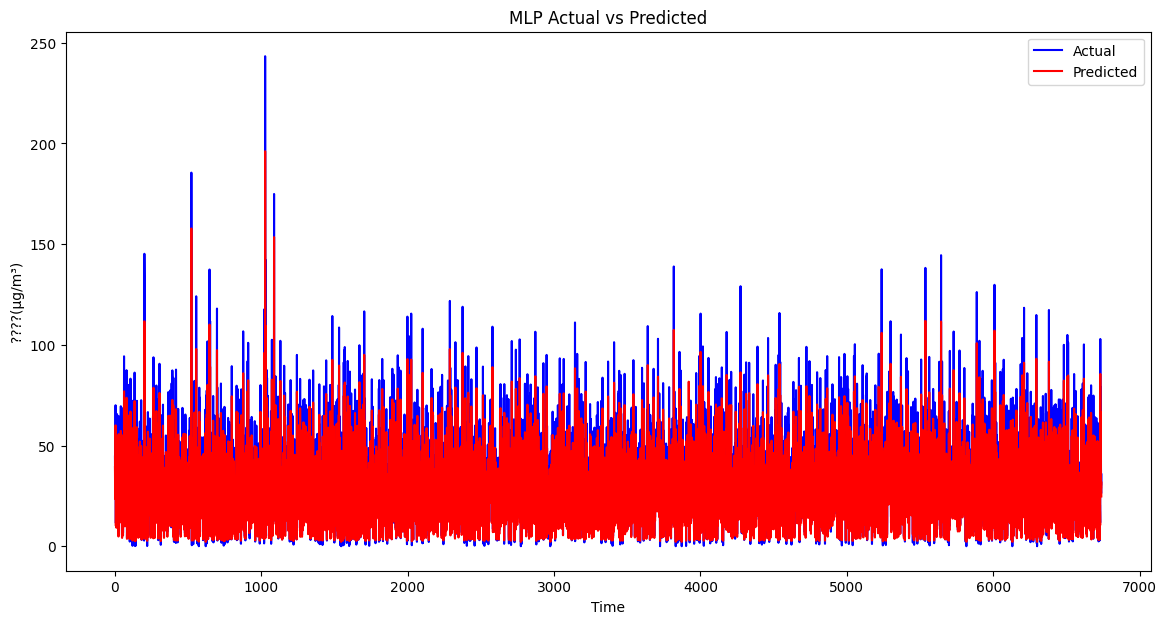

RMSE of MLP Model : 6.2066
R-squared of MLP Model : 0.9145


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


# y_test 가져오기
test_data = pd.read_csv("test_data.csv")
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_test = test_data["관측미세먼지"].values

#y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

#바로 아래 주석처리된부분이 코드 원본이고, 아래에 #### ~ #### 부분이 전처리와 호환되도록 다시 작성한 코드입니다.
#dataset_size = len(X)
#train_size = int(0.8 * dataset_size)
#test_size = dataset_size - train_size
#y_train, y_test = torch.split(y, [train_size, test_size])

#################
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
###############


# 예측값 가져오기, MLP만 테스트했기때문에, 나머지는 주석처리했음. 나중에 주석지우면됨
actual_values = y_test.cpu().numpy()
predicted_values_MLP = np.load('MLP.npy')
#predicted_values_Transformer = np.load('Transformer.npy')
#predicted_values_LSTM = np.load('LSTM.npy')

def evaluate_model(actual_values, predicted_values):

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # R-squared 계산
    r2 = r2_score(actual_values, predicted_values)

    return rmse, r2

def visualize_model(actual_values, predicted_values, model_name):

    time = np.arange(len(predicted_values))

    plt.figure(figsize=(14, 7))
    plt.plot(time, actual_values, label='Actual', color='blue')
    plt.plot(time, predicted_values, label='Predicted', color='red')
    plt.xlabel('Time')
    plt.ylabel('????(μg/m³)')
    plt.title(f'{model_name} Actual vs Predicted')
    plt.legend()
    plt.show()


rmse_MLP, r2_MLP = evaluate_model(actual_values, predicted_values_MLP)
visualize_model(actual_values, predicted_values_MLP, 'MLP')
print(f'RMSE of MLP Model : {rmse_MLP:.4f}')
print(f'R-squared of MLP Model : {r2_MLP:.4f}')

# MLP 만 측정했기때문에 나머지 주석처리했음. 모두 테스트하려면 주석만 지우면 끝

#rmse_Transformer, r2_Transformer = evaluate_model(actual_values, predicted_values_Transformer)
#visualize_model(actual_values, predicted_values_Transformer, 'Transformer')
#print(f'RMSE of Transformer Model : {rmse_Transformer:.4f}')
#print(f'R-squared of Transformer Model : {r2_Transformer:.4f}')

#rmse_LSTM, r2_LSTM = evaluate_model(actual_values, predicted_values_LSTM)
#visualize_model(actual_values, predicted_values_LSTM, 'LSTM')
#print(f'RMSE of LSTM Model : {rmse_LSTM:.4f}')
#print(f'R-squared of LSTM Model : {r2_LSTM:.4f}')


평과결과:
아무래도 실수밸류가 타켓이라 정확도보단 오차로 모델의 성능을 판단해야하는데. 나온 그래프를 보니,실제 결과보다 조금씩 모자라게 평가하는 것을 볼 수 있습니다.
만약 팀원중에 이 부분을 좀더 보완가능한 방법을 알려주시면 자유롭게 수정,업로드하셔도 좋습니다!
